In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef
import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
from calibration_functions import huxt_rank_functions as hrf

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number
import astropy.units as u

from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

In [3]:
cr = 2239
MAS_vr_map, MAS_vr_longs, MAS_vr_lats = Hin.get_MAS_vr_map(cr = cr)

VR_INT = hrf.interpolate_vmap(velocity_map=MAS_vr_map.value, lats=MAS_vr_lats, longs=MAS_vr_longs)

forecast_window = 5*u.day
E_lat = hrf.get_earth_lat(forecast_window, cr=cr, cr_lon_init=360*u.deg) # Get Earth latitude for sub earth paths

# HUXt model parameters
dt_scale = 4
r_min = 30*u.solRad

# Getting MAS map bits for interpolation and sub earth paths
MAS_vr_map, MAS_vr_longs, MAS_vr_lats = Hin.get_MAS_vr_map(cr = cr)
interpolated_MAS_vmap = hrf.interpolate_vmap(MAS_vr_map.value, MAS_vr_lats.value, MAS_vr_longs.value)

tilt = 15
perturbed_path = hrf.perturb_path(E_lat, tilt, MAS_vr_longs, 0, 1) # Random amplitude and phase, Fixed wave number

# Generate perturbed velocity boundary
velocity_boundary = hrf.extract_interpolated_velocity_boundary(interpolated_MAS_vmap, perturbed_path, MAS_vr_longs.to(u.deg))

Files already exist for CR2239
Files already exist for CR2239


In [8]:
def generate_perturbed_sub_earth_path(lat_earth, phase_phi, longitudes_theta, no_members, max_lat_dev):
    rng = np.random.default_rng(444)

    wave_numbers = np.ones(no_members)
    phase_offsets = rng.normal(loc = phase_phi, scale = 60, size = no_members)
    lat_deviations = rng.normal(loc = lat_earth, scale = max_lat_dev, size = no_members)

    perturbed_sub_earth_path = []
    
    for lat_dev, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        perturbed_sub_earth_path.append(lat_earth + lat_dev*np.sin(wave_no*(longitudes_theta) + phase_off) + np.pi/2)

    return perturbed_sub_earth_path*u.rad

In [103]:
E_lat.value

-0.04543579079823569

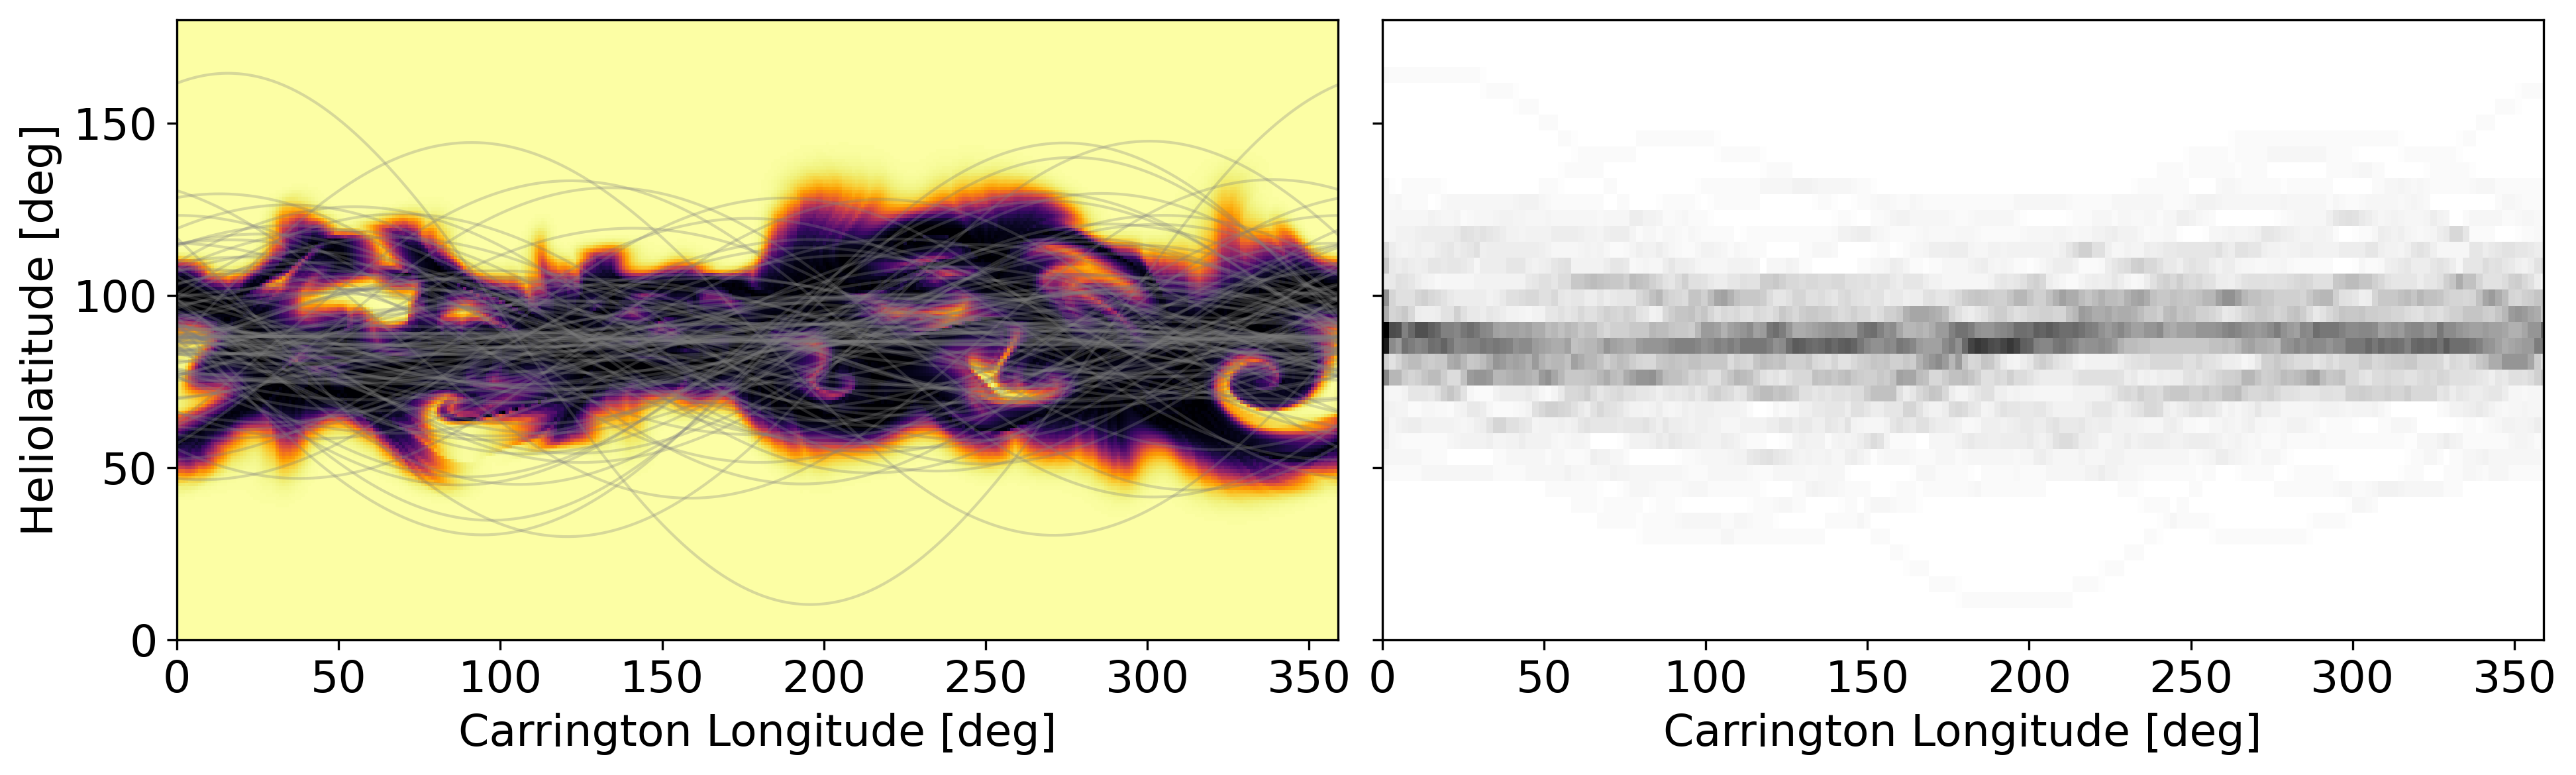

In [108]:
sigma_lat = np.radians(30)
sub_earth_path_pert = generate_perturbed_sub_earth_path(E_lat.value, 2*np.pi, MAS_vr_longs.value, 100, sigma_lat)

waves = []
for wave in sub_earth_path_pert:
    waves.append((MAS_vr_longs.to(u.deg).value, np.degrees(wave).value))

# Define bins for histogram
x_bins = np.linspace(0, 360, 180)  
y_bins = np.linspace(0, 180, 40)  

# Create empty 2D histogram
hist = np.zeros((len(x_bins) - 1, len(y_bins) - 1))

# Calculate histogram
for x, y in waves:
    hist_tmp, _, _ = np.histogram2d(x, y, bins=(x_bins, y_bins))
    hist += hist_tmp

# Plotting
fig,axes = plt.subplots(nrows = 1, ncols =2, dpi = 300, figsize = (13,4), sharey = True)
axes[0].imshow(MAS_vr_map.value, origin = 'lower', cmap = 'inferno', aspect='auto')
[axes[0].plot(MAS_vr_longs.to(u.deg).value, np.degrees(path), color = 'grey', alpha = 0.3, lw = 1) for path in sub_earth_path_pert]

axes[1].imshow(hist.T, extent=[x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()],origin='lower', aspect='auto', cmap='Greys')
axes[1].set_xlim(0,359)
axes[1].set_ylim(0,180)

axes[0].set_xlim(0,359)
axes[0].set_ylim(0,180)

axes[0].set_xlabel('Carrington Longitude [deg]')
axes[1].set_xlabel('Carrington Longitude [deg]')
axes[0].set_ylabel('Heliolatitude [deg]')

plt.tight_layout()

plt.show()